In [1]:
import cdsapi
import xarray as xr
import pandas as pd
import numpy as np
import os, zipfile
from entsoe import EntsoePandasClient
import matplotlib.pyplot as plt, pandas as pd
import statsmodels.formula.api as smf
from dataclasses import dataclass
import cvxpy as cp

(CVXPY) Jun 25 01:10:21 PM: Encountered unexpected exception importing solver ECOS:
ImportError("dlopen(/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so, 0x0002): tried: '/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64')), '/System/Volumes/Preboot/Cryptexes/OS/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (no such file), '/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'arm64e' or 'arm64'))")
(CVXPY) Jun 25 01:10:22 PM: Encountered unexpected exception importing solver ECOS_BB:
ImportError("dlopen(/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so, 0x0002): tried: '/opt/anaconda3/lib/python3.11/site-packages/_ecos.cpython-311-darwin.so' (mach-o file, but is an incompatible architecture (have 'x86_64', need 'ar

In [3]:
# ──────────────────────────────────────────────────────────────
# ENTSO-E  •  NL  •  2019-01  •  Solar / Wind / Hydro + Prices
# ──────────────────────────────────────────────────────────────
client = EntsoePandasClient(api_key="898c2e0a-7960-483e-b21e-9fe8317b76ea")

country_code = "NL"
start, end   = (pd.Timestamp("2019-01-01", tz="Europe/Amsterdam"),
                pd.Timestamp("2019-07-01", tz="Europe/Amsterdam"))

# Generation by technology
generation = client.query_generation(country_code, start=start, end=end)

# Day-ahead prices (€/MWh) – already hourly
prices = client.query_day_ahead_prices(country_code, start=start, end=end)

# 2️⃣  Keep only the 'Actual Aggregated' sub-columns
generation = generation.xs('Actual Aggregated', level=1, axis=1)

# 3️⃣  Select & rename
renewables = generation[["Solar", "Wind Onshore", "Hydro Run-of-river and poundage"]]
renewables = renewables.rename(columns={
    "Solar": "solar_MW",
    "Wind Onshore": "wind_MW",
    "Hydro Run-of-river and poundage": "hydro_MW"#,
    #"wind forecast": "wind_da_t-1d",
    #"solar forecast": "solar_da_t-1d"
})

# 4️⃣  Merge with prices, resample, drop NaNs
df_entsoe = (
    renewables
    .assign(price_EUR_MWh=prices)
    .resample("1H").mean()
    .dropna()
)

# Persist
outdir = "/Users/ozgunbaris/Documents/BDS/Thesis/Codes/Data"
os.makedirs(outdir, exist_ok=True)
df_entsoe.to_csv(f"{outdir}/entsoe_nl_2019_01-07.csv")




/var/folders/6c/_gj0x3n53hsbwrnjfvwbkfrh0000gn/T/ipykernel_15512/3985368347.py:33: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .resample("1H").mean()


In [5]:
print("✅ ENTSO-E data:", df_entsoe.shape, "rows")
print(df_entsoe.tail(20))

✅ ENTSO-E data: (4343, 4) rows
                           solar_MW  wind_MW  hydro_MW  price_EUR_MWh
2019-06-30 04:00:00+02:00      0.00   569.25       0.0          19.60
2019-06-30 05:00:00+02:00      0.25   563.75       0.0          10.16
2019-06-30 06:00:00+02:00      2.50   610.25       0.0          12.27
2019-06-30 07:00:00+02:00      8.00   605.25       0.0          14.55
2019-06-30 08:00:00+02:00     17.75   477.00       0.0          20.67
2019-06-30 09:00:00+02:00     22.75   395.75       0.0          17.24
2019-06-30 10:00:00+02:00     36.25   354.75       0.0          17.40
2019-06-30 11:00:00+02:00     44.25   308.50       0.0          20.10
2019-06-30 12:00:00+02:00     47.75   356.75       0.0          33.05
2019-06-30 13:00:00+02:00     47.75   236.75       0.0          24.36
2019-06-30 14:00:00+02:00     35.25   167.75       0.0          21.72
2019-06-30 15:00:00+02:00     40.75   135.50       0.0          25.84
2019-06-30 16:00:00+02:00     44.50   166.25       0.0     

In [8]:
# ──────────────────────────────────────────────────────────────
# ERA-5 LAND • NL • Jan-Jun 2019  (patched)
# ──────────────────────────────────────────────────────────────
import os, zipfile, calendar
import cdsapi, xarray as xr, numpy as np, pandas as pd

# ―― download six months of data (Jan–Jun 2019) ─────────────────
c            = cdsapi.Client()
base_dir     = "/Users/ozgunbaris/Documents/BDS/Thesis/Codes"
extract_dir  = os.path.join(base_dir, "era5_weather_extracted")
os.makedirs(extract_dir, exist_ok=True)

months       = range(1, 7)                             # 01‒06 inclusive
zip_files    = []

for m in months:
    days_in_month = calendar.monthrange(2019, m)[1]
    month_str     = f"{m:02d}"
    zip_name      = f"era5_nl_2019_{month_str}.nc.zip"
    zip_path      = os.path.join(base_dir, zip_name)
    zip_files.append(zip_path)

    c.retrieve(
        "reanalysis-era5-land",
        {
            "variable": [
                "2m_temperature",
                "10m_u_component_of_wind",
                "10m_v_component_of_wind",
                "surface_solar_radiation_downwards"
            ],
            "year"  : "2019",
            "month" : month_str,
            "day"   : [f"{d:02d}" for d in range(1, days_in_month + 1)],
            "time"  : [f"{h:02d}:00" for h in range(24)],
            "area"  : [53.7, 3.3, 50.5, 7.3],             # N, W, S, E  (NL box)
            "format": "netcdf"
        },
        zip_path
    )

# ―― unzip, process each month, then concatenate ───────────────
dfs_weather = []

for m, zip_path in zip(months, zip_files):
    month_str   = f"{m:02d}"
    month_dir   = os.path.join(extract_dir, f"2019_{month_str}")
    os.makedirs(month_dir, exist_ok=True)

    # 1) extract *only* the .nc file into its month-specific dir
    with zipfile.ZipFile(zip_path, "r") as z:
        nc_in_zip = next(n for n in z.namelist() if n.endswith(".nc"))
        z.extract(nc_in_zip, month_dir)

    nc_path = os.path.join(month_dir, os.path.basename(nc_in_zip))

    # 2) open dataset
    ds = xr.open_dataset(nc_path)

    # 3) hourly spatial mean
    df_tmp   = ds.to_dataframe().reset_index()
    time_col = "time" if "time" in df_tmp.columns else "valid_time"
    df_tmp   = (
        df_tmp
        .groupby(time_col)[["t2m", "u10", "v10", "ssrd"]]
        .mean()
    )

    # 4) unit conversions
    df_tmp = (
        df_tmp.assign(
            temperature_C   = df_tmp["t2m"] - 273.15,
            solar_Wm2       = df_tmp["ssrd"] / 3600,                    # J h⁻¹ → W m⁻²
            wind_speed_mps  = np.sqrt(df_tmp["u10"]**2 + df_tmp["v10"]**2)
        )
        .rename(columns={"u10": "u10_mps", "v10": "v10_mps"})
        .drop(columns=["t2m", "ssrd"])
    )

    # 5) timezone handling + 1-hour accumulation-lag fix
    df_tmp.index = (
        df_tmp.index
          .tz_localize("UTC")               # ERA-5 timestamps are UTC
          .tz_convert("Europe/Amsterdam")   # convert to NL local time
          - pd.Timedelta(hours=1)           # shift back 1 h (ssrd lag)
    )

    dfs_weather.append(df_tmp)

# ―― final tidy dataframe covering Jan-Jun 2019 ────────────────
df_weather = pd.concat(dfs_weather).sort_index()
df_weather.index.name = "utc"


2025-06-25 16:40:13,438 WARNING [2025-06-23T00:00:00] Scheduled System Session affecting Service reliability - 30 June 2025. Please follow status [here](https://status.ecmwf.int/) or in our [forum](https://forum.ecmwf.int/t/scheduled-maintenance-of-the-cloud-infrastructure-on-30-june-2025/13598)
2025-06-25 16:40:13,438 INFO [2025-06-16T00:00:00] CC-BY licence to replace Licence to use Copernicus Products on 02 July 2025. More information available [here](https://forum.ecmwf.int/t/cc-by-licence-to-replace-licence-to-use-copernicus-products-on-02-july-2025/13464)
2025-06-25 16:40:13,439 INFO [2025-06-10T00:00:00] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.
2025-06-25 16:40:13,439 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-06-25 16:40:13,641 INFO Request ID is ac02183d-422a-4e19-a3b8-1a193304ca10
2025-06

736ffff65e8852eff21e2fdfe8e853bd.zip:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

2025-06-25 16:40:29,634 INFO Request ID is 76fd05a0-9526-4f92-adc2-93b2799121b6
2025-06-25 16:40:29,705 INFO status has been updated to accepted
2025-06-25 16:40:43,479 INFO status has been updated to successful


65cc743b42a8f038616fca1c91559698.zip:   0%|          | 0.00/4.55M [00:00<?, ?B/s]

2025-06-25 16:40:45,675 INFO Request ID is 50b8eb53-102a-4962-b0a2-862261230294
2025-06-25 16:40:45,736 INFO status has been updated to accepted
2025-06-25 16:40:50,776 INFO status has been updated to running
2025-06-25 16:40:54,229 INFO status has been updated to successful


b7ac2b4bb43e9c99899ac699207986a2.zip:   0%|          | 0.00/5.27M [00:00<?, ?B/s]

2025-06-25 16:40:56,324 INFO Request ID is 10ae4308-355d-4314-b8a4-ac0c6c6cd279
2025-06-25 16:40:56,477 INFO status has been updated to accepted
2025-06-25 16:41:17,747 INFO status has been updated to successful


46cbc41de15aa2e03c1b6a8f581b384c.zip:   0%|          | 0.00/5.20M [00:00<?, ?B/s]

2025-06-25 16:41:19,696 INFO Request ID is 7da0e6f2-e46d-4c1f-bffa-c87b97ea9d9c
2025-06-25 16:41:19,827 INFO status has been updated to accepted
2025-06-25 16:41:26,112 INFO status has been updated to successful


b29691327bb9afe1eacb47a1d71aa895.zip:   0%|          | 0.00/5.56M [00:00<?, ?B/s]

2025-06-25 16:41:28,611 INFO Request ID is 44a30fca-7d3f-4213-8af4-1417d1c32338
2025-06-25 16:41:28,699 INFO status has been updated to accepted
2025-06-25 16:41:33,719 INFO status has been updated to running
2025-06-25 16:41:37,173 INFO status has been updated to successful


5db90c4ac5abbcb3fd75a5a289bf14d0.zip:   0%|          | 0.00/5.45M [00:00<?, ?B/s]

In [4]:
# ──────────────────────────────────────────────────────────────
# ERA-5 LAND • NL • Jan-2019  (patched)
# ──────────────────────────────────────────────────────────────
c = cdsapi.Client()
c.retrieve(
    "reanalysis-era5-land",
    {
        "variable": [
            "2m_temperature",
            "10m_u_component_of_wind",
            "10m_v_component_of_wind",
            "surface_solar_radiation_downwards"
        ],
        "year": "2019",
        "month": "01",
        "day": [f"{d:02d}" for d in range(1, 32)],
        "time": [f"{h:02d}:00" for h in range(24)],
        "area": [53.7, 3.3, 50.5, 7.3],   # N, W, S, E (NL box)
        "format": "netcdf"
    },
    "era5_nl_2019_01.nc.zip"
)

zip_path    = "/Users/ozgunbaris/Documents/BDS/Thesis/Codes/era5_nl_2019_01.nc.zip"
extract_dir = "/Users/ozgunbaris/Documents/BDS/Thesis/Codes/era5_weather_extracted"
os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, "r") as z:
    z.extractall(extract_dir)

nc_file = next(f for f in os.listdir(extract_dir) if f.endswith(".nc"))
ds      = xr.open_dataset(os.path.join(extract_dir, nc_file))

# ── make time a column, group → hourly spatial mean
df_weather = ds.to_dataframe().reset_index()
time_col   = "time" if "time" in df_weather.columns else "valid_time"

df_weather = (
    df_weather
    .groupby(time_col)[["t2m", "u10", "v10", "ssrd"]]
    .mean()
)

# ── unit conversions
df_weather = df_weather.assign(
    temperature_C   = df_weather["t2m"] - 273.15,
    solar_Wm2       = df_weather["ssrd"] / 3600,                      # J h⁻¹ → W
    wind_speed_mps  = np.sqrt(df_weather["u10"]**2 + df_weather["v10"]**2)
).rename(columns={"u10": "u10_mps", "v10": "v10_mps"}) \
 .drop(columns=["t2m", "ssrd"])

# ── timezone handling + ALIGNMENT FIX
df_weather.index = (
    df_weather.index
      .tz_localize("UTC")               # ERA-5 times are UTC
      .tz_convert("Europe/Amsterdam")   # convert to local clock
      - pd.Timedelta(hours=1)           # ← shift back 1 h (ssrd accumulation lag)
)
df_weather.index.name = "utc"



2025-05-13 10:45:21,590 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-13 10:45:21,591 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-13 10:45:21,814 INFO Request ID is 4e6e59d0-bbcf-4a00-b0b5-3bdb50bb0103
2025-05-13 10:45:21,909 INFO status has been updated to accepted
2025-05-13 10:45:30,661 INFO status has been updated to successful


7098fb87a87b223ced915a018d960429.zip:   0%|          | 0.00/4.98M [00:00<?, ?B/s]

In [10]:
print("✅ ERA-5 weather:", df_weather.shape, "rows")
print(df_weather.tail())

✅ ERA-5 weather: (4344, 5) rows
                            u10_mps   v10_mps  temperature_C    solar_Wm2  \
utc                                                                         
2019-06-30 20:00:00+02:00  2.644957 -1.060102      21.672424  7459.779785   
2019-06-30 21:00:00+02:00  1.997366 -0.739278      20.508667  7482.446777   
2019-06-30 22:00:00+02:00  1.768985 -0.167182      19.483704  7482.446777   
2019-06-30 23:00:00+02:00  1.930367  0.512343      18.563049  7482.446777   
2019-07-01 00:00:00+02:00  2.272730  0.867267      17.880707  7482.446777   

                           wind_speed_mps  
utc                                        
2019-06-30 20:00:00+02:00        2.849494  
2019-06-30 21:00:00+02:00        2.129790  
2019-06-30 22:00:00+02:00        1.776867  
2019-06-30 23:00:00+02:00        1.997201  
2019-07-01 00:00:00+02:00        2.432582  


In [12]:
# 0️⃣  FLATTEN ENTSO-E COLUMNS  (drop 2nd level if present)
if isinstance(df_entsoe.columns, pd.MultiIndex):
    df_entsoe.columns = df_entsoe.columns.get_level_values(0)

# 1️⃣  ENTSO-E index  → Europe/Amsterdam  (keep LOCAL clock)
if df_entsoe.index.tz is None:
    df_entsoe.index = df_entsoe.index.tz_localize("Europe/Amsterdam")
else:
    df_entsoe.index = df_entsoe.index.tz_convert("Europe/Amsterdam")
df_entsoe.index.name = "utc"        # keep name 'utc' for clarity

# 2️⃣  ERA-5 index  (always UTC)  → Europe/Amsterdam
df_weather = df_weather.copy()      # avoid mutating original
if "utc" in df_weather.columns:
    if df_weather["utc"].dt.tz is None:
        df_weather["utc"] = df_weather["utc"].dt.tz_localize("UTC")
    df_weather.set_index("utc", inplace=True)
elif df_weather.index.tz is None:
    df_weather.index = df_weather.index.tz_localize("UTC")

df_weather.index = df_weather.index.tz_convert("Europe/Amsterdam")
df_weather.index.name = "utc"

# 3️⃣  INNER JOIN  (indices now align, single-level columns)
df_merged = df_entsoe.join(df_weather, how="inner")

print("Merged rows:", len(df_merged))
print(df_merged.head())

# 4️⃣  SAVE
outdir = "/Users/ozgunbaris/Documents/BDS/Thesis/Codes"
os.makedirs(outdir, exist_ok=True)
df_merged.to_csv(os.path.join(outdir, "merged_dataset_7month.csv"))
print("✅ Saved merged dataset (local time).")

Merged rows: 4343
                           solar_MW  wind_MW  hydro_MW  price_EUR_MWh  \
utc                                                                     
2019-01-01 00:00:00+01:00       0.0   670.00       0.0          68.92   
2019-01-01 01:00:00+01:00       0.0   693.00       0.0          64.98   
2019-01-01 02:00:00+01:00       0.0   734.75       0.0          60.27   
2019-01-01 03:00:00+01:00       0.0   778.00       0.0          49.97   
2019-01-01 04:00:00+01:00       0.0   804.50       0.0          47.66   

                            u10_mps   v10_mps  temperature_C   solar_Wm2  \
utc                                                                        
2019-01-01 00:00:00+01:00  4.050956  1.354894       7.214386  408.520599   
2019-01-01 01:00:00+01:00  4.300704  1.285044       7.137695    0.000000   
2019-01-01 02:00:00+01:00  4.548635  1.055783       7.108643    0.000000   
2019-01-01 03:00:00+01:00  4.759119  0.806365       7.050262    0.000000   
2019-01-01 04:

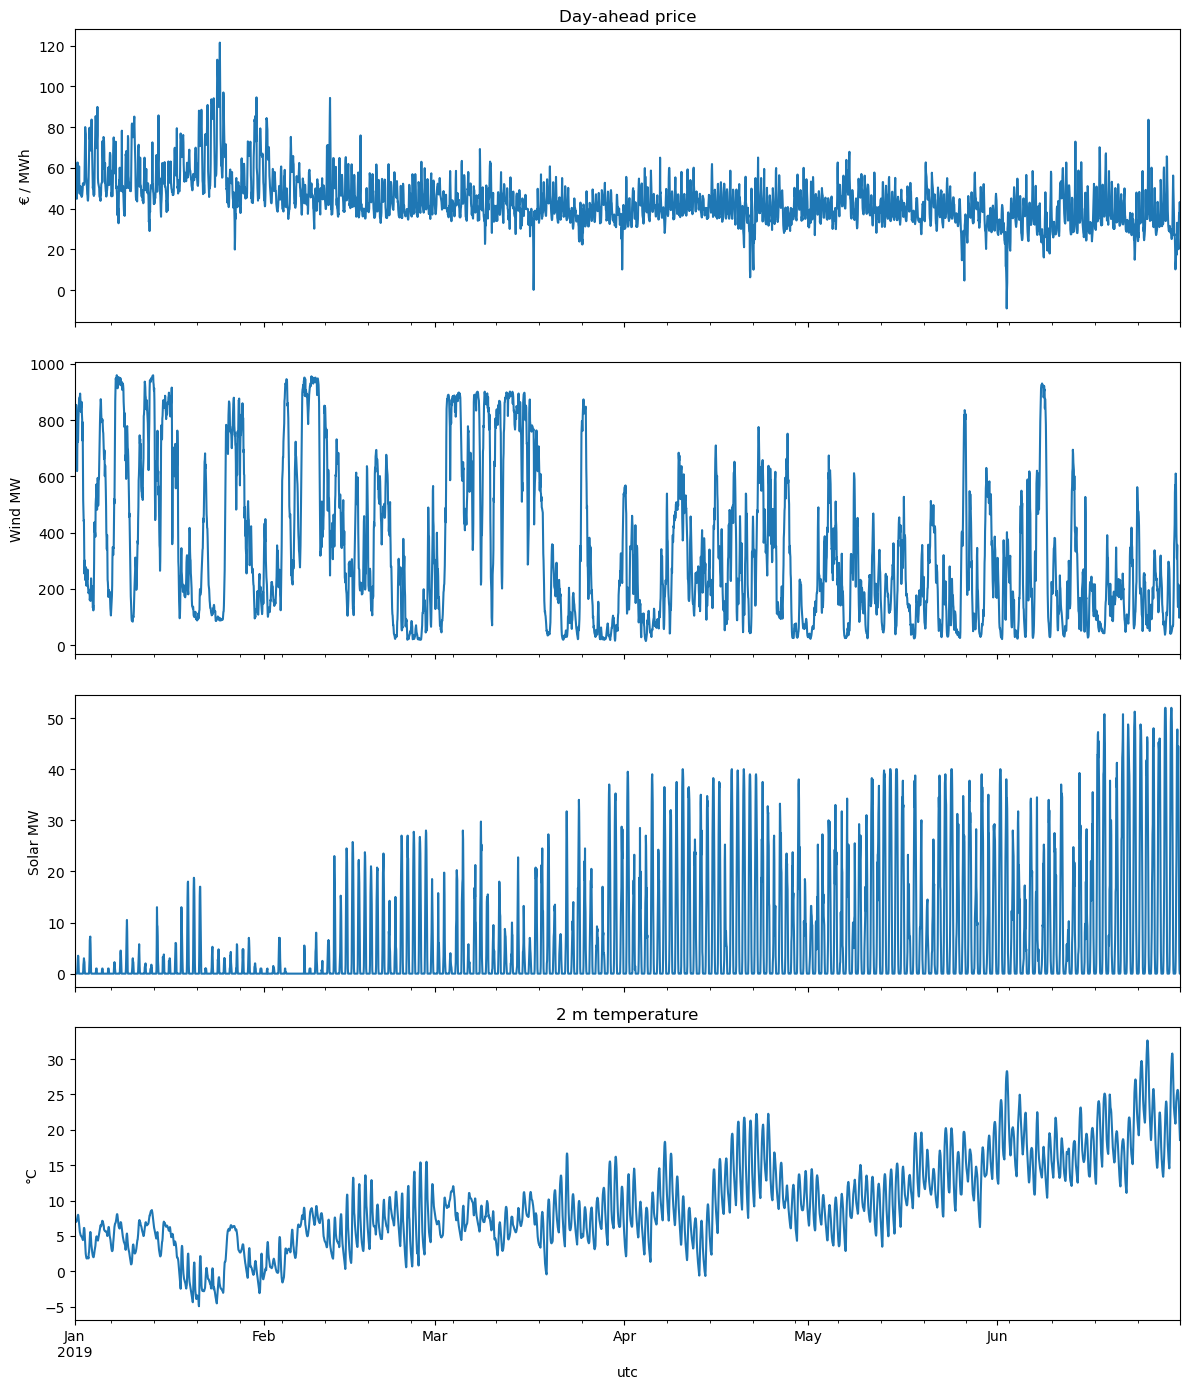

In [13]:
#Sanity Checks
# Merge on UTC
df = df_merged

# 1. Time-series overview
fig, axs = plt.subplots(4, 1, figsize=(12, 14), sharex=True)
df["price_EUR_MWh"].plot(ax=axs[0]); axs[0].set_ylabel("€ / MWh"); axs[0].set_title("Day-ahead price")
df["wind_MW"].plot(ax=axs[1]);       axs[1].set_ylabel("Wind MW")
df["solar_MW"].plot(ax=axs[2]);      axs[2].set_ylabel("Solar MW")
df["temperature_C"].plot(ax=axs[3]); axs[3].set_ylabel("°C"); axs[3].set_title("2 m temperature")
plt.tight_layout(); plt.show()


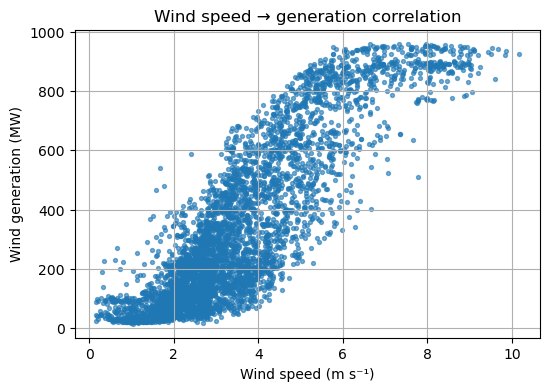

In [14]:
# ─────────────────────────────────────────────────────────────
# 2. Wind speed  vs  wind generation
# ─────────────────────────────────────────────────────────────
_tmp = df[["wind_speed_mps", "wind_MW"]].dropna()
plt.figure(figsize=(6,4))
plt.scatter(_tmp["wind_speed_mps"], _tmp["wind_MW"], s=8, alpha=0.6)
plt.xlabel("Wind speed (m s⁻¹)"); plt.ylabel("Wind generation (MW)")
plt.title("Wind speed → generation correlation"); plt.grid(True); plt.show()




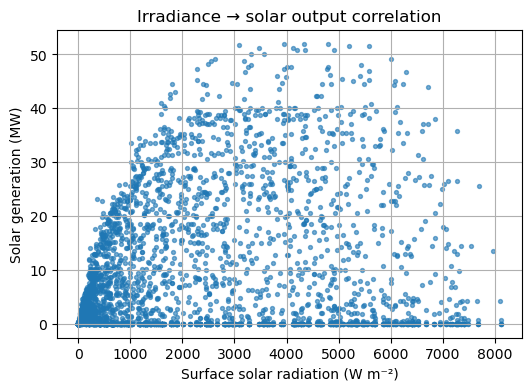

In [15]:
# 3. Solar radiation vs solar generation
plt.figure(figsize=(6,4))
plt.scatter(df["solar_Wm2"], df["solar_MW"], s=8, alpha=0.6)
plt.xlabel("Surface solar radiation (W m⁻²)")
plt.ylabel("Solar generation (MW)")
plt.title("Irradiance → solar output correlation")
plt.grid(True); plt.show()

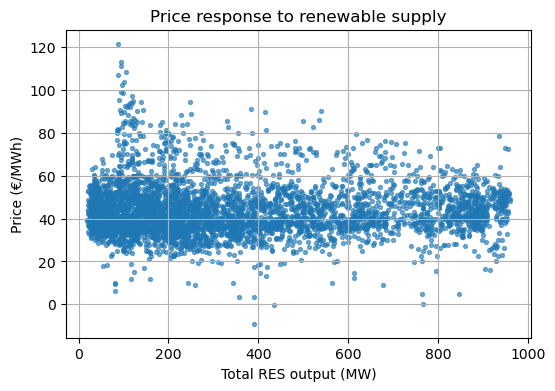

In [16]:

# 4. Price vs total renewable output
df["renew_total_MW"] = df["wind_MW"] + df["solar_MW"] + df["hydro_MW"]
plt.figure(figsize=(6,4))
plt.scatter(df["renew_total_MW"], df["price_EUR_MWh"], s=8, alpha=0.6)
plt.xlabel("Total RES output (MW)")
plt.ylabel("Price (€/MWh)")
plt.title("Price response to renewable supply")
plt.grid(True); plt.show()

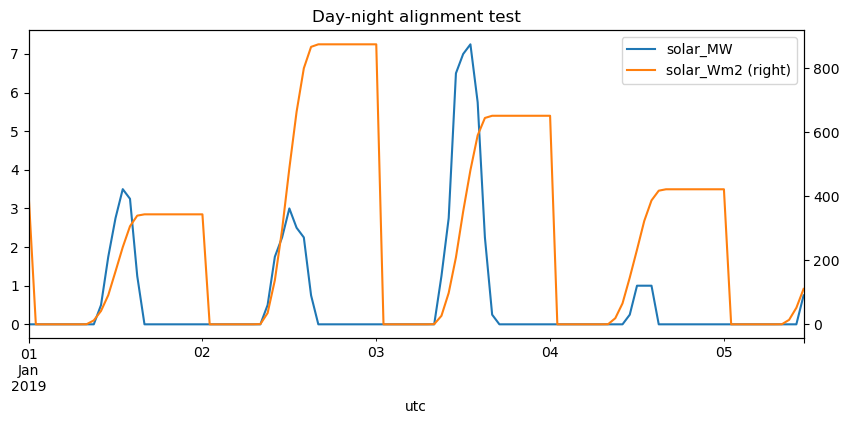

In [17]:
# 2️⃣  Check time alignment visually
df_tmp = df_entsoe[["solar_MW"]].join(df_weather["solar_Wm2"])
df_tmp.iloc[:108].plot(secondary_y="solar_Wm2", figsize=(10,4))  # first 3 days
plt.title("Day-night alignment test"); plt.show()

In [18]:
# df_merged = final dataset from earlier merge (local time, Jan-2019)
print(df_merged.describe(percentiles=[.05,.5,.95]).T[['count','mean','min','max']])


                 count         mean        min          max
solar_MW        4343.0     7.125259   0.000000    52.000000
wind_MW         4343.0   343.914402  14.500000   960.000000
hydro_MW        4343.0     0.000000   0.000000     0.000000
price_EUR_MWh   4343.0    43.839970  -9.020000   121.460000
u10_mps         4343.0     0.993976  -5.865001     9.497135
v10_mps         4343.0     0.509763  -6.815582     8.428488
temperature_C   4343.0     9.530517  -4.948456    32.646088
solar_Wm2       4343.0  1866.306885   0.000000  8114.289062
wind_speed_mps  4343.0     3.569298   0.156271    10.160939
renew_total_MW  4343.0   351.039662  19.000000   960.000000


In [19]:
# Basic linear + saturation term for irradiance
df = df_merged.copy()
df['irradiance_kW'] = df['solar_Wm2'] / 1000          # easier scale
df['irradiance_sq'] = df['irradiance_kW']**2          # captures clipping
df['temp_C_center'] = df['temperature_C'] - df['temperature_C'].mean()

solar_model = smf.ols(
    'solar_MW ~ irradiance_kW + irradiance_sq + temp_C_center',
    data=df
).fit()

print(solar_model.summary())


                            OLS Regression Results                            
Dep. Variable:               solar_MW   R-squared:                       0.451
Model:                            OLS   Adj. R-squared:                  0.450
Method:                 Least Squares   F-statistic:                     1187.
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:51:25   Log-Likelihood:                -15489.
No. Observations:                4343   AIC:                         3.099e+04
Df Residuals:                    4339   BIC:                         3.101e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         4.7011      0.214     21.988

In [20]:
# wind power curves ~ v³ until rated speed, then flat
df['wind_mps_sq']   = df['wind_speed_mps']**2
df['wind_mps_cu']   = df['wind_speed_mps']**3

wind_model = smf.ols(
    'wind_MW ~ wind_speed_mps + wind_mps_sq + wind_mps_cu',
    data=df
).fit()

print(wind_model.summary())


                            OLS Regression Results                            
Dep. Variable:                wind_MW   R-squared:                       0.768
Model:                            OLS   Adj. R-squared:                  0.767
Method:                 Least Squares   F-statistic:                     4776.
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:51:27   Log-Likelihood:                -27326.
No. Observations:                4343   AIC:                         5.466e+04
Df Residuals:                    4339   BIC:                         5.469e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         92.3623     13.466      6.

In [21]:
#Saved fitted values for later use.
df['solar_fit_MW'] = solar_model.fittedvalues
df['wind_fit_MW']  = wind_model.fittedvalues
df.to_csv(os.path.join(outdir, 'nl_renew_weather_models_2019_01.csv'))


In [22]:
#How do renewables & weather affect day-ahead prices?
# df_merged  ← output from Step 1 (local time, good solar series)

df = df_merged.copy()

# 1️⃣  Create total renewable supply & renewable share proxy
df["renew_MW"]      = df["wind_MW"] + df["solar_MW"] + df["hydro_MW"]
df["renew_share"]   = df["renew_MW"] / df["renew_MW"].max()           # simple proxy

# 2️⃣  Add demand-side proxy – temperature (colder → higher load in NL Jan)
df["temp_C_center"] = df["temperature_C"] - df["temperature_C"].mean()

# 3️⃣  Create hour-of-day dummies to soak up intraday structure
df["hour"] = df.index.hour
hour_dummies = pd.get_dummies(df["hour"], prefix="h", drop_first=True)
df = pd.concat([df, hour_dummies], axis=1)

formula = (
    "price_EUR_MWh ~ renew_MW + temp_C_center "
    "+ " + " + ".join(hour_dummies.columns)     # adds h_1 … h_23
)

price_model = smf.ols(formula, data=df).fit(cov_type="HC1")  # robust SEs
print(price_model.summary())



                            OLS Regression Results                            
Dep. Variable:          price_EUR_MWh   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     131.7
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:51:33   Log-Likelihood:                -15462.
No. Observations:                4343   AIC:                         3.098e+04
Df Residuals:                    4317   BIC:                         3.114e+04
Df Model:                          25                                         
Covariance Type:                  HC1                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        39.1066      0.487     80.233

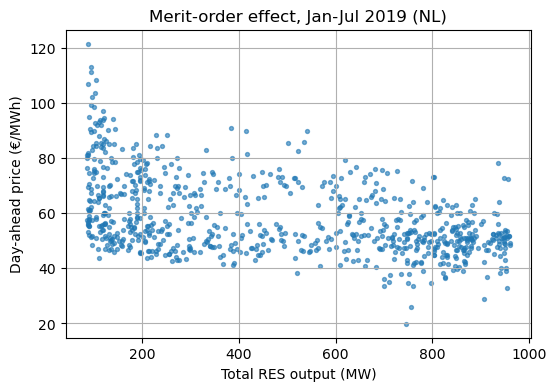

In [31]:
plt.figure(figsize=(6,4))
plt.scatter(df["renew_MW"], df["price_EUR_MWh"], s=8, alpha=0.6)
plt.xlabel("Total RES output (MW)")
plt.ylabel("Day-ahead price (€/MWh)")
plt.title("Merit-order effect, Jan-Jul 2019 (NL)")
plt.grid(True); plt.show()

In [24]:
# ------------------------------------------------------------
# Load series (OPSD)  •  Jan-2019  •  Netherlands
# ------------------------------------------------------------
url = "https://data.open-power-system-data.org/time_series/latest/time_series_60min_singleindex.csv"

load_nl = (
    pd.read_csv(
        url,
        usecols=['utc_timestamp', 'NL_load_actual_entsoe_transparency'],
        parse_dates=['utc_timestamp']
    )
    .rename(columns={'utc_timestamp': 'utc',
                     'NL_load_actual_entsoe_transparency': 'load_MW'})
    .set_index('utc')
    .loc['2019-01-01':'2019-02-01']          # January only
)

# ── make sure index is tz-aware UTC, then convert to Europe/Amsterdam
if load_nl.index.tz is None:
    load_nl.index = load_nl.index.tz_localize('UTC')
load_nl.index = load_nl.index.tz_convert('Europe/Amsterdam')

print("Peak load (MW):", load_nl['load_MW'].max())



Peak load (MW): 18020.0


In [25]:
df = df_merged.join(load_nl, how='inner')   

print(df[['load_MW']].describe())

            load_MW
count    768.000000
mean   14401.792969
std     2204.518593
min    10413.000000
25%    12257.500000
50%    14468.000000
75%    16616.250000
max    18020.000000


In [26]:
df.head()

,solar_MW,wind_MW,hydro_MW,price_EUR_MWh,u10_mps,v10_mps,temperature_C,solar_Wm2,wind_speed_mps,renew_total_MW,load_MW
utc,,,,,,,,,,,
2019-01-01 01:00:00+01:00,0.0,693.00,0.0,64.98,4.300704,1.285044,7.137695,0.0,4.488585,693.00,11194.0
2019-01-01 02:00:00+01:00,0.0,734.75,0.0,60.27,4.548635,1.055783,7.108643,0.0,4.669557,734.75,10933.0
2019-01-01 03:00:00+01:00,0.0,778.00,0.0,49.97,4.759119,0.806365,7.050262,0.0,4.826949,778.00,10667.0
2019-01-01 04:00:00+01:00,0.0,804.50,0.0,47.66,4.916848,0.561395,7.027405,0.0,4.948794,804.50,10413.0
2019-01-01 05:00:00+01:00,0.0,854.25,0.0,48.00,4.993318,0.298765,6.973083,0.0,5.002247,854.25,10441.0


In [27]:
# ------------------------------------------------------------
# 0.  Make sure required columns exist
# ------------------------------------------------------------
if "renew_MW" not in df.columns:
    df["renew_MW"] = df["wind_MW"] + df["solar_MW"] + df["hydro_MW"]

if "resid_demand_MW" not in df.columns:
    df["resid_demand_MW"] = df["load_MW"] - df["renew_MW"]

if "temp_C_center" not in df.columns:
    df["temp_C_center"] = df["temperature_C"] - df["temperature_C"].mean()

# hour-of-day dummies (creates h_1 … h_23)
if "hour" not in df.columns:
    df["hour"] = df.index.hour
    df = pd.concat(
        [df, pd.get_dummies(df["hour"], prefix="h", drop_first=True)],
        axis=1
    )

# ------------------------------------------------------------
# 1.  Build RHS safely
# ------------------------------------------------------------
hour_cols  = df.filter(like="h_").columns.tolist()
rhs_terms  = ["temp_C_center", "wind_speed_mps", "solar_Wm2"] + hour_cols
formula    = "resid_demand_MW ~ " + " + ".join(rhs_terms)

print("Using formula:\n", formula)

# ------------------------------------------------------------
# 2.  Fit OLS with robust SEs
# ------------------------------------------------------------
import statsmodels.formula.api as smf
load_model = smf.ols(formula, data=df).fit(cov_type="HC1")
print(load_model.summary())



Using formula:
 resid_demand_MW ~ temp_C_center + wind_speed_mps + solar_Wm2 + h_1 + h_2 + h_3 + h_4 + h_5 + h_6 + h_7 + h_8 + h_9 + h_10 + h_11 + h_12 + h_13 + h_14 + h_15 + h_16 + h_17 + h_18 + h_19 + h_20 + h_21 + h_22 + h_23
                            OLS Regression Results                            
Dep. Variable:        resid_demand_MW   R-squared:                       0.806
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     233.6
Date:                Tue, 01 Jul 2025   Prob (F-statistic):               0.00
Time:                        11:52:09   Log-Likelihood:                -6389.0
No. Observations:                 768   AIC:                         1.283e+04
Df Residuals:                     741   BIC:                         1.296e+04
Df Model:                          26                                         
Covariance Type:                  HC1                       

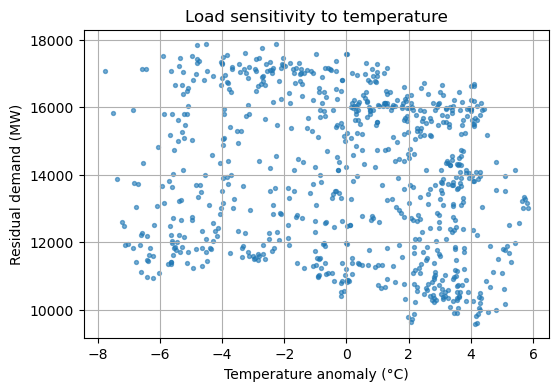

In [32]:
plt.figure(figsize=(6,4))
plt.scatter(df['temp_C_center'], df['resid_demand_MW'], s=8, alpha=0.6)
plt.xlabel("Temperature anomaly (°C)")
plt.ylabel("Residual demand (MW)")
plt.title("Load sensitivity to temperature"); plt.grid(True); plt.show()

df['load_fit_MW']  = load_model.fittedvalues
df['load_resid_MW'] = load_model.resid
df.to_csv(os.path.join(outdir, "nl_load_weather_2019_01.csv"))


In [27]:
# Save
df_merged.to_csv("merged_dataset.csv", index=True)




In [3]:
import pandas as pd

df_merged = pd.read_csv("merged_dataset.csv")


In [4]:
df_merged.head()

,utc,solar_MW,wind_MW,hydro_MW,price_EUR_MWh,u10_mps,v10_mps,temperature_C,solar_Wm2,wind_speed_mps,renew_total_MW
0,2019-01-01 00:00:00+01:00,0.0,670.00,0.0,68.92,4.050956,1.354894,7.214386,408.5206,4.271532,670.00
1,2019-01-01 01:00:00+01:00,0.0,693.00,0.0,64.98,4.300705,1.285044,7.137695,0.0000,4.488585,693.00
2,2019-01-01 02:00:00+01:00,0.0,734.75,0.0,60.27,4.548635,1.055783,7.108643,0.0000,4.669557,734.75
3,2019-01-01 03:00:00+01:00,0.0,778.00,0.0,49.97,4.759119,0.806365,7.050262,0.0000,4.826949,778.00
4,2019-01-01 04:00:00+01:00,0.0,804.50,0.0,47.66,4.916848,0.561395,7.027405,0.0000,4.948794,804.50


In [24]:
###Second Part of the Code
#hourly = df_merged.copy()

In [6]:
# ──────────────────────────────────────────────────────────────
#  Diagnostics for lagged-weather relevance
#    1. Distributed-lag coefficient curves
#    2. Granger-causality / IC comparison
# ──────────────────────────────────────────────────────────────
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from statsmodels.iolib.summary2 import summary_col

# --------------------------------------------------------------
# CONFIG – you can tweak these lists
# --------------------------------------------------------------
weather_vars   = ["wind_speed_mps", "solar_Wm2", "temperature_C"]
outcome_map    = {"wind_speed_mps": "wind_MW",
                  "solar_Wm2"    : "solar_MW",
                  "temperature_C": "price_EUR_MWh"}   # choose any outcome
max_lag        = 24                # hours
test_lag_grid  = [0, 6, 12, 24]    # models to compare in IC table
alpha          = 0.05              # CI level

# --------------------------------------------------------------
# 1. Distributed-lag regressions + plots
# --------------------------------------------------------------
coef_store = {}         # for later
ci_low, ci_high = {}, {}

for x in weather_vars:
    y = outcome_map[x]
    # build lagged design matrix
    X_list = [df_merged[x].shift(k) for k in range(max_lag + 1)]
    X = pd.concat(X_list, axis=1)
    X.columns = [f"{x}_lag{k}" for k in range(max_lag + 1)]
    data = pd.concat([df_merged[y], X], axis=1).dropna()

    Y = data[y]
    X = sm.add_constant(data[X.columns])
    model = sm.OLS(Y, X).fit(cov_type="HC1")

    # store coefficients and CI
    coef_store[x]   = model.params.filter(like=x)
    conf_int        = model.conf_int(alpha=alpha).loc[coef_store[x].index]
    ci_low[x]       = conf_int[0]
    ci_high[x]      = conf_int[1]

    # ---- plot impulse response style
    hrs = np.arange(max_lag + 1)
    plt.figure(figsize=(6,3))
    plt.plot(hrs, coef_store[x], marker="o")
    plt.fill_between(hrs, ci_low[x], ci_high[x], alpha=0.3)
    plt.axhline(0, ls="--", c="k", lw=0.7)
    plt.title(f"Distributed-lag response: {x} → {y}")
    plt.xlabel("Lag (h)")
    plt.ylabel("Coefficient")
    plt.tight_layout()
    #plt.savefig(f"dl_response_{x}.png", dpi=150)
    plt.close()


In [7]:
# --------------------------------------------------------------
# 2. Granger-causality / IC comparison
# --------------------------------------------------------------
rows = []
for x in weather_vars:
    y = outcome_map[x]
    for L in test_lag_grid:
        # build minimal model with given number of lags
        X_list = [df_merged[x].shift(k) for k in range(L+1)]
        X = pd.concat(X_list, axis=1)
        X.columns = [f"{x}_lag{k}" for k in range(L+1)]
        data = pd.concat([df_merged[y], X], axis=1).dropna()
        Y = data[y]
        X = sm.add_constant(data[X.columns])
        m   = sm.OLS(Y, X).fit(cov_type="HC1")
        rows.append({"weather": x, "lags": L,
                     "AIC": m.aic, "BIC": m.bic})

ic_df = pd.DataFrame(rows)
# normalise IC by subtracting the no-lag value (easier to read)
ic_df["ΔAIC"] = ic_df.groupby("weather")["AIC"].transform(lambda s: s - s.iloc[0])
ic_df["ΔBIC"] = ic_df.groupby("weather")["BIC"].transform(lambda s: s - s.iloc[0])
ic_df.to_csv("granger_ic_table.csv", index=False)
print(ic_df)

# optional: pretty view
display_cols = ["weather", "lags", "AIC", "BIC", "ΔAIC", "ΔBIC"]
print("\nInformation-criterion comparison (lower is better):")
print(ic_df[display_cols].to_string(index=False))

           weather  lags          AIC          BIC        ΔAIC        ΔBIC
0   wind_speed_mps     0  9069.173881  9078.397963    0.000000    0.000000
1   wind_speed_mps     6  8995.161345  9031.992896  -74.012536  -46.405067
2   wind_speed_mps    12  8925.464120  8989.805047 -143.709761  -88.592916
3   wind_speed_mps    24  8808.383321  8927.443853 -260.790560 -150.954110
4        solar_Wm2     0  3576.541286  3585.765368    0.000000    0.000000
5        solar_Wm2     6  3381.617187  3418.448738 -194.924098 -167.316630
6        solar_Wm2    12  3209.574870  3273.915797 -366.966416 -311.849570
7        solar_Wm2    24  3009.966279  3129.026810 -566.575007 -456.738558
8    temperature_C     0  5902.319121  5911.543203    0.000000    0.000000
9    temperature_C     6  5717.055810  5753.887360 -185.263312 -157.655843
10   temperature_C    12  5582.544362  5646.885289 -319.774759 -264.657914
11   temperature_C    24  5395.858069  5514.918600 -506.461053 -396.624603

Information-criterion co